<a href="https://colab.research.google.com/github/devanandini0210/zinc_detector/blob/main/RetinaNet_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting google drive and unzipping the dataset
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/Master_Thesis/dataset.zip" -d /content/

Mounted at /content/drive


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#defining the dataset class
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ])
        self.label_paths = [
            os.path.join(label_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.image_paths
        ]
        self.transforms = T.Compose([
                 T.ToTensor(),
                 T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      h, w = image.shape[:2]

      boxes, labels = [], []
      with open(self.label_paths[idx], "r") as f:
          for line in f:
              parts = line.strip().split()
              if len(parts) != 5:
                  continue
              cls, xc, yc, bw, bh = map(float, parts)
              x1 = (xc - bw / 2) * w
              y1 = (yc - bh / 2) * h
              x2 = (xc + bw / 2) * w
              y2 = (yc + bh / 2) * h

              if x2 <= x1 or y2 <= y1:  #skipping the invalid boxes
                  continue

              boxes.append([x1, y1, x2, y2])
              labels.append(int(cls) + 1)

      if len(boxes) == 0:
          return None  #skipping samples with no valid boxes

      target = {
          "boxes": torch.tensor(boxes, dtype=torch.float32),
          "labels": torch.tensor(labels, dtype=torch.int64),
          "image_id": torch.tensor(idx)
      }

      image = self.transforms(image)
      return image, target

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights, RetinaNetClassificationHead

def get_model(num_classes=2):
    #loading the base model with pretrained weights
    model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)

    #setting up classification head
    in_channels = model.backbone.out_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(in_channels, num_anchors, num_classes)
    return model

In [ ]:
train_img_dir = "/content/dataset/images/train"
train_lbl_dir = "/content/dataset/labels/train"
val_img_dir   = "/content/dataset/images/val"
val_lbl_dir   = "/content/dataset/labels/val"

#creating training and validation datasets
train_dataset = YoloDataset(train_img_dir, train_lbl_dir)
val_dataset   = YoloDataset(val_img_dir, val_lbl_dir)

In [ ]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))

#creating training and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
#defining the validation function
def evaluate(model, dataloader, device):
    model.train()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2).to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.001, momentum=0.9, weight_decay=0.0005)

model.train()
best_val_loss = float('inf')

#training the model
for epoch in range(30):
    model.train()
    total_loss = 0.0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())

            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}, batch {i+1}")
                print(loss_dict)
                print("Sample target:", targets[0])
                continue

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        except Exception as e:
            print(f"Exception in batch {i+1}: {e}")
            continue

    avg_train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader, device)


    print(f"Epoch {epoch+1} — Train Loss: {avg_train_loss:.4f} — Val Loss: {val_loss:.4f}")

    #saving the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "retinanet_best.pth")
        print(f"Best model saved at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

Epoch 1 — Train Loss: 1.2203 — Val Loss: 0.6132
Best model saved at epoch 1 (Val Loss: 0.6132)
Epoch 2 — Train Loss: 0.3706 — Val Loss: 0.3044
Best model saved at epoch 2 (Val Loss: 0.3044)
Epoch 3 — Train Loss: 0.2629 — Val Loss: 0.2597
Best model saved at epoch 3 (Val Loss: 0.2597)
Epoch 4 — Train Loss: 0.2248 — Val Loss: 0.2634
Epoch 5 — Train Loss: 0.1990 — Val Loss: 0.2242
Best model saved at epoch 5 (Val Loss: 0.2242)
Epoch 6 — Train Loss: 0.1806 — Val Loss: 0.2159
Best model saved at epoch 6 (Val Loss: 0.2159)
Epoch 7 — Train Loss: 0.1643 — Val Loss: 0.2132
Best model saved at epoch 7 (Val Loss: 0.2132)
Epoch 8 — Train Loss: 0.1528 — Val Loss: 0.2048
Best model saved at epoch 8 (Val Loss: 0.2048)
Epoch 9 — Train Loss: 0.1413 — Val Loss: 0.2117
Epoch 10 — Train Loss: 0.1317 — Val Loss: 0.2025
Best model saved at epoch 10 (Val Loss: 0.2025)
Epoch 11 — Train Loss: 0.1230 — Val Loss: 0.2058
Epoch 12 — Train Loss: 0.1180 — Val Loss: 0.2219
Epoch 13 — Train Loss: 0.1145 — Val Loss: 0.

In [ ]:
#downloading the best model
from google.colab import files
files.download("retinanet_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_img_dir = "/content/dataset/images/test"
test_lbl_dir = "/content/dataset/labels/test"

#creating the test dataset and dataloaders
test_dataset = YoloDataset(test_img_dir, test_lbl_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
model.load_state_dict(torch.load("retinanet_best.pth"))
model.to(device)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import time
from collections import defaultdict
from torchvision.ops import box_iou
import torch

#evaluating the model
def evaluate_retinanet(model, dataloader, device, iou_threshold=0.5, num_classes=2):
    model.eval()
    all_preds = defaultdict(list)
    all_gts = defaultdict(list)
    total_tp = total_fp = total_fn = 0
    inference_times = []


    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            start = time.time()
            outputs = model(images)
            end = time.time()

            inference_times.append(end - start)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                pred_scores = output['scores']
                gt_boxes = target['boxes']
                gt_labels = target['labels']


                for cls in range(1, num_classes):
                    pred_mask = pred_labels == cls
                    gt_mask = gt_labels == cls

                    preds = pred_boxes[pred_mask]
                    scores = pred_scores[pred_mask]
                    gts = gt_boxes[gt_mask]

                    all_preds[cls].append((preds.cpu(), scores.cpu()))
                    all_gts[cls].append(gts.cpu())

                ious = box_iou(pred_boxes, gt_boxes)
                matched_gt = set()
                tp = 0
                for i in range(len(pred_boxes)):
                    iou_vals = ious[i]
                    max_iou, max_idx = torch.max(iou_vals, dim=0)
                    if max_iou >= iou_threshold and max_idx.item() not in matched_gt:
                        tp += 1
                        matched_gt.add(max_idx.item())

                fp = len(pred_boxes) - tp
                fn = len(gt_boxes) - tp
                total_tp += tp
                total_fp += fp
                total_fn += fn


    #calculating evaluation metrics
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    avg_inference = sum(inference_times) / len(inference_times)
    fps = 1.0 / avg_inference

    #calculating class-wise AP
    def compute_ap(gt, pred, iou_thresh=0.5):
        if len(gt) == 0 and len(pred[0]) == 0:
            return 1.0
        if len(gt) == 0 or len(pred[0]) == 0:
            return 0.0
        preds, scores = pred
        preds = preds[scores > 0.05]
        if len(preds) == 0:
            return 0.0
        ious = box_iou(preds, gt)
        matched = set()
        tp = 0
        for i in range(len(preds)):
            max_iou, max_idx = torch.max(ious[i], dim=0)
            if max_iou >= iou_thresh and max_idx.item() not in matched:
                tp += 1
                matched.add(max_idx.item())
        fp = len(preds) - tp
        fn = len(gt) - tp
        p = tp / (tp + fp + 1e-6)
        r = tp / (tp + fn + 1e-6)
        return (p * r) / (p + r + 1e-6)

    ap_per_class = {}
    for cls in range(1, num_classes):
        aps = []
        for gt, pred in zip(all_gts[cls], all_preds[cls]):
            ap = compute_ap(gt, pred)
            aps.append(ap)
        ap_avg = sum(aps) / len(aps) if aps else 0.0
        ap_per_class[cls] = ap_avg

    map_val = sum(ap_per_class.values()) / len(ap_per_class) if ap_per_class else 0.0

    #com[puting model information
    params = sum(p.numel() for p in model.parameters())
    size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / 1024**2

    #printing the results
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1 Score:      {f1_score:.4f}")
    print(f"mAP@0.5:       {map_val:.4f}")
    print(f"Inference Time: {avg_inference:.4f} sec/image")
    print(f"FPS:           {fps:.2f} frames/sec")
    print(f"Model Parameters: {params:,}")
    print(f"Model Size:    {size_mb:.2f} MB")
    print(f"\nAP per Class:")
    for cls, ap in ap_per_class.items():
        print(f"  Class {cls}: AP = {ap:.4f}")

In [ ]:
evaluate_retinanet(model, test_loader, device, iou_threshold=0.5, num_classes=2)

Precision:     0.5997
Recall:        0.9488
F1 Score:      0.7349
mAP@0.5:       0.3780
Inference Time: 0.0750 sec/image
FPS:           13.33 frames/sec
Model Parameters: 32,168,694
Model Size:    122.71 MB

AP per Class:
  Class 1: AP = 0.3780


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix
from torchvision.ops import box_iou

In [ ]:
from torchvision.ops import box_iou

#initialisisng lists
y_scores = []
y_true = []
all_ious = []
all_confidences = []
gt_all = []
pred_all = []
fp_centers = []
fn_centers = []

#extracting information for visualisations
model.eval()
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes'].cpu()
            pred_labels = output['labels'].cpu()
            pred_scores = output['scores'].cpu()
            gt_boxes = target['boxes'].cpu()
            gt_labels = target['labels'].cpu()

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()

            for i in range(len(pred_boxes)):
              score = pred_scores[i].item()
              label = pred_labels[i].item()
              y_scores.append(score)
              all_confidences.append(score)

              if gt_boxes.size(0) > 0:
                  max_iou, max_idx = torch.max(ious[i], dim=0)
                  all_ious.append(max_iou.item())
                  gt_label = gt_labels[max_idx].item()

                  if max_iou >= 0.5 and max_idx.item() not in matched_gt and label == gt_label:
                      y_true.append(1)
                      matched_gt.add(max_idx.item())

                      pred_all.append(label)
                      gt_all.append(gt_label)
                  else:
                      y_true.append(0)

                      pred_all.append(label)
                      gt_all.append(0)
                      x_center = (pred_boxes[i][0] + pred_boxes[i][2]) / 2
                      y_center = (pred_boxes[i][1] + pred_boxes[i][3]) / 2
                      fp_centers.append((x_center.item(), y_center.item()))
              else:
                  all_ious.append(0.0)
                  y_true.append(0)

                  pred_all.append(label)
                  gt_all.append(0)



            for j in range(len(gt_boxes)):
                if j not in matched_gt:

                    x_center = (gt_boxes[j][0] + gt_boxes[j][2]) / 2
                    y_center = (gt_boxes[j][1] + gt_boxes[j][3]) / 2
                    fn_centers.append((x_center.item(), y_center.item()))

                    pred_all.append(0)
                    gt_all.append(gt_labels[j].item())

100%|██████████| 204/204 [00:20<00:00, 10.04it/s]


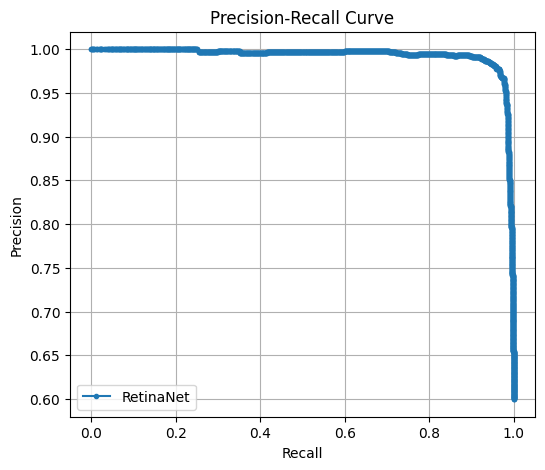

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#plotting the PR curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label='RetinaNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

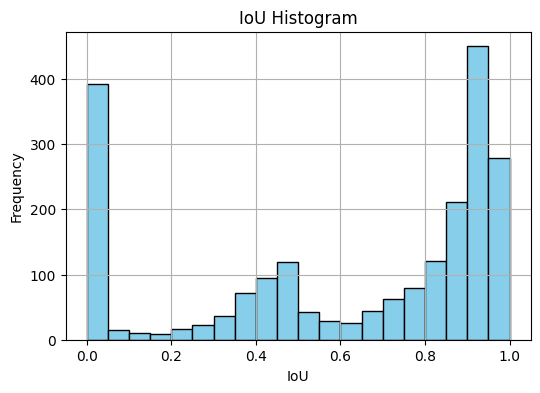

In [ ]:
#plotting the IoU Histogram
def plot_iou_histogram(ious, bins=20):
    plt.figure(figsize=(6, 4))
    plt.hist(ious, bins=bins, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title("IoU Histogram")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_iou_histogram(all_ious)

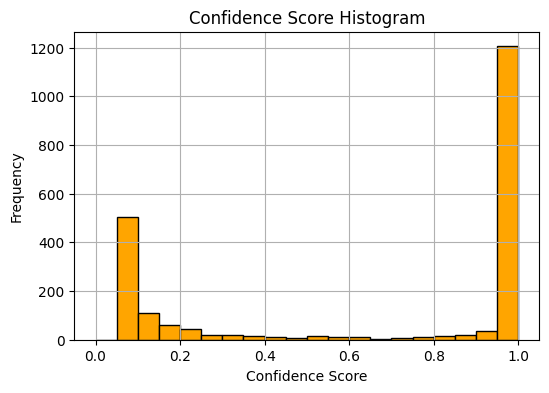

In [ ]:
#plotting the Confidence score histogram
def plot_confidence_histogram(confidences, bins=20):
    plt.figure(figsize=(6, 4))
    plt.hist(confidences, bins=bins, range=(0, 1), color='orange', edgecolor='black')
    plt.title("Confidence Score Histogram")
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_confidence_histogram(all_confidences)

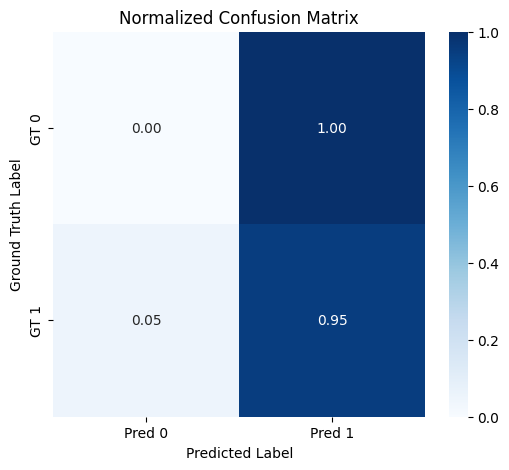

In [ ]:
#plotting the normalised confusion matrix
def plot_confusion_matrix(gt_all, pred_all, num_classes):
    cm = confusion_matrix(gt_all, pred_all, labels=list(range(num_classes)))
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[f"Pred {i}" for i in range(num_classes)],
                yticklabels=[f"GT {i}" for i in range(num_classes)])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Ground Truth Label")
    plt.show()

plot_confusion_matrix(gt_all, pred_all, num_classes=2)

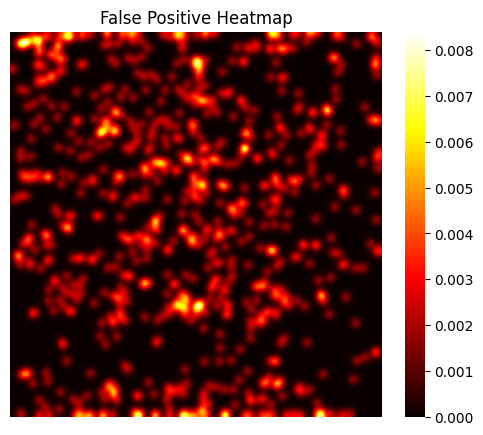

In [ ]:
from scipy.ndimage import gaussian_filter

#plotting the FP heatmap
def plot_fp_heatmap(fp_centers, image_shape=(1024, 1024), sigma=10):
    heatmap = np.zeros(image_shape, dtype=np.float32)

    for x, y in fp_centers:
        x = int(round(x))
        y = int(round(y))
        if 0 <= y < image_shape[0] and 0 <= x < image_shape[1]:
            heatmap[y, x] += 1

    #smoothing the heatmap to enlarge the dots
    heatmap_smooth = gaussian_filter(heatmap, sigma=sigma)

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_smooth, cmap="hot", cbar=True)
    plt.title("False Positive Heatmap")
    plt.axis("off")
    plt.show()

plot_fp_heatmap(fp_centers, image_shape=(1024, 1024), sigma=10)

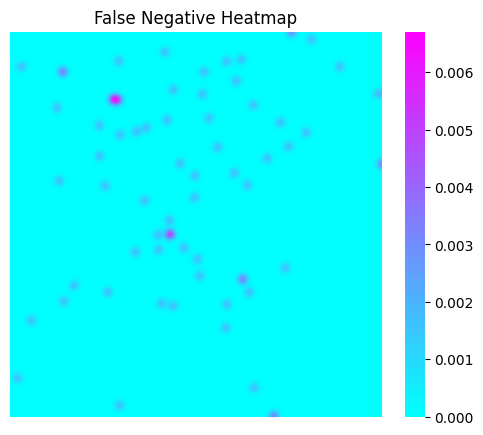

In [ ]:
#plotting the FN heatmap
def plot_fn_heatmap(fn_centers, image_shape=(1024, 1024), sigma=10):
    heatmap = np.zeros(image_shape, dtype=np.float32)

    for x, y in fn_centers:
        x = int(round(x))
        y = int(round(y))
        if 0 <= y < image_shape[0] and 0 <= x < image_shape[1]:
            heatmap[y, x] += 1  # row-major: (y, x)

    heatmap_smooth = gaussian_filter(heatmap, sigma=sigma)

    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_smooth, cmap="cool", cbar=True)
    plt.title("False Negative Heatmap")
    plt.axis("off")
    plt.show()

plot_fn_heatmap(fn_centers, image_shape=(1024, 1024), sigma=10)

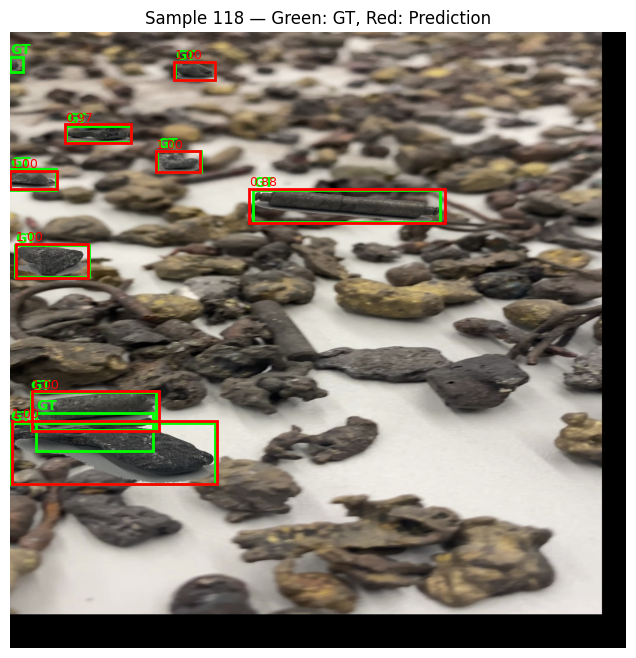

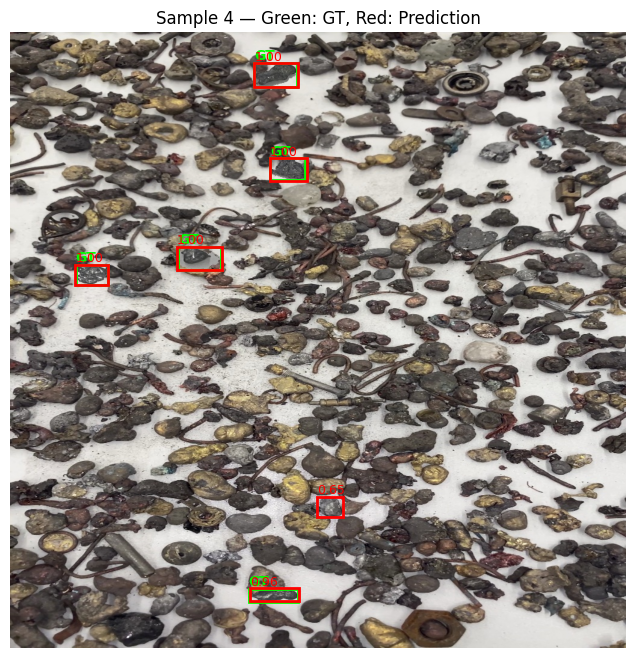

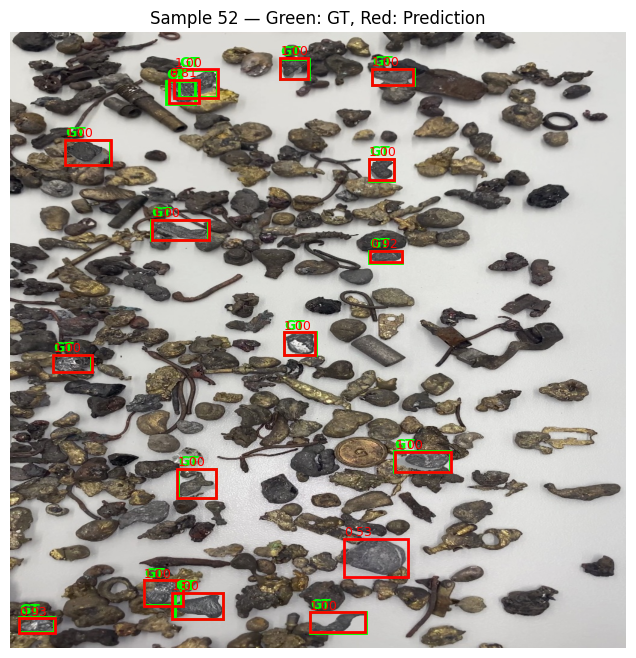

In [ ]:
import random
import cv2
from matplotlib import patches

#unnormalising the images
def unnormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean

#overlaying prediction and ground truth over sample images
def overlay_predictions_and_gt(model, dataset, device, num_images=3, score_thresh=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    for idx in indices:
        image, target = dataset[idx]
        img_disp = unnormalize(image).permute(1, 2, 0).clamp(0, 1).numpy()

        with torch.no_grad():
            output = model([image.to(device)])[0]

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(img_disp)

        #drawing the GT boxes in green
        for box in target['boxes']:
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, 'GT', color='lime', fontsize=10, weight='bold')

        #drawing the predicted boxes in red
        for i in range(len(output['boxes'])):
            score = output['scores'][i].item()
            if score >= score_thresh:
                x1, y1, x2, y2 = output['boxes'][i].cpu().tolist()
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1 - 5, f"{score:.2f}", color='red', fontsize=9)

        ax.set_title(f"Sample {idx} — Green: GT, Red: Prediction")
        ax.axis("off")
        plt.show()

overlay_predictions_and_gt(model, test_dataset, device, num_images=3, score_thresh=0.5)